# Load Data

In [3]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.append('../')
import pandas as pd
import tqdm
import warnings
import copy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import networkx as nx
import numpy as np
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import csv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
## Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"predictions.h5")

In [5]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "La Liga"]
print("nb of games:", len(games))

nb of games: 348


# Helper Functions

In [6]:
def teams_in_game(actions):
    team1 = actions.loc[0]["team_name"]
    for i in range(1, len(actions)):
        team2 = actions.loc[i]["team_name"]
        if (team2 != team1):
            return team1, team2

In [7]:
def game_pass_list(actions, team1):
    edges1 = []
    edges2 = []
    pass_action = ['pass', 'throw_in', 'corner_crossed', 'freekick_crossed', 'cross', 
                  'freekick_short', 'goalkick', 'corner_short']
    
    for i in range(len(actions)):
        action = actions.loc[i]["type_name"]
          
        if action in pass_action:
            if actions.loc[i]["result_name"] == 'success':
                passer = actions.loc[i]["player_name"]
                team = actions.loc[i]["team_name"]
                j = 1
                while i+j < len(actions) and (actions.loc[i+j]["team_name"] != team):
                    j += 1
                try:
                    passer = actions.loc[i]["player_name"]
                    receiver = actions.loc[i+j]["player_name"]
                    if team == team1:
                        edges1.append((passer, receiver))
                    else:
                        edges2.append((passer, receiver))
                except:
                    continue
                
    return edges1, edges2

In [8]:
def create_graph(passes):
    G = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(passes).items())
    return G

In [9]:
def get_total_links(G):
    DV = G.degree(weight='weight')
    return sum(deg for n, deg in DV)/2

In [10]:
def get_metrics(G):
    total_links = get_total_links(G)
    density = nx.density(G)
    diameter = nx.diameter(G.to_undirected())
    average_clustering = nx.average_clustering(G)
    
    return total_links, density, diameter, average_clustering

In [11]:
def compute_average(team_props):
    average = {}
    
    for team in team_props.keys():
        average[team] = [np.mean(team_props[team][0]), np.mean(team_props[team][1]), 
                         np.mean(team_props[team][2]), np.mean(team_props[team][3])]
    
    return average

In [12]:
def la_liga_team_placements():
    placements = {}
    
    with open('./Contributions/La_Liga_Standings.csv', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[-1] != "Average":
                placements[row[0]] = float(row[-1])
                
    return placements
    
la_liga_team_placements()

{'Barcelona': 1.416666667,
 'Las Palmas': 11.0,
 'Rayo Vallecano': 12.8,
 'Real Madrid': 1.833333333,
 'Real Murcia': 19.0,
 'Valencia': 5.666666667,
 'Celta Vigo': 10.66666667,
 'Villarreal': 6.090909091,
 'Sevilla': 5.666666667,
 'Atlético Madrid': 5.5,
 'Real Betis': 12.66666667,
 'Athletic Bilbao': 9.583333333,
 'Getafe': 12.91666667,
 'Real Valladolid': 16.2,
 'Deportivo La Coruna': 12.5,
 'Real Zaragoza': 13.75,
 'Recreativo Huelva': 14.66666667,
 'Mallorca': 11.77777778,
 'Deportivo Alavés': 18.0,
 'Gimnàstic Tarragona': 20.0,
 'Real Sociedad': 11.77777778,
 'Elche': 14.5,
 'Cádiz': 19.0,
 'Eibar': 15.0,
 'Albacete': 20.0,
 'Espanyol': 11.33333333,
 'Almería': 14.66666667,
 'Málaga': 10.2,
 'Racing Santander': 13.625,
 'Hércules': 19.0,
 'Córdoba': 20.0,
 'Granada': 16.2,
 'Osasuna': 12.6,
 'Levante': 14.11111111,
 'Tenerife': 19.0,
 'Xerez': 20.0,
 'Sporting Gijón': 15.4,
 'Numancia': 19.0}

# Compute Network Metrics

In [13]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

In [14]:
team_props = {}

for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    
    team1, team2 = teams_in_game(actions)
    passes1, passes2 = game_pass_list(actions, team1)
    G1 = create_graph(passes1)
    G2 = create_graph(passes2)
    
    total_links1, density1, diameter1, avg_clustering1 = get_metrics(G1)
    total_links2, density2, diameter2, avg_clustering2 = get_metrics(G2)

    if team1 in team_props:
        team_props[team1][0].append(total_links1)
        team_props[team1][1].append(density1)
        team_props[team1][2].append(diameter1)
        team_props[team1][3].append(avg_clustering1)
    else:
        team_props[team1] = [[total_links1], [density1], [diameter1], [avg_clustering1]]
        
    if team2 in team_props:
        team_props[team2][0].append(total_links2)
        team_props[team2][1].append(density2)
        team_props[team2][2].append(diameter2)
        team_props[team2][3].append(avg_clustering2)
    else:
        team_props[team2] = [[total_links2], [density2], [diameter2], [avg_clustering2]]   

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 348/348 [06:09<00:00,  1.08it/s]


In [15]:
average = compute_average(team_props)
placements = la_liga_team_placements()

In [16]:
ordered_teams = OrderedDict(sorted(average.items(), key=lambda x: x[1][0], reverse=True))
for team in ordered_teams:
    print(team + " (" + '{:.2f}'.format(placements[team]) + ") : " + str(ordered_teams[team]))

Barcelona (1.42) : [596.8879310344828, 0.6804074756660965, 2.089080459770115, 0.7810436931552017]
Las Palmas (11.00) : [351.0, 0.6126373626373627, 2.0, 0.7003518548776995]
Rayo Vallecano (12.80) : [307.0, 0.5909645909645911, 2.2222222222222223, 0.70315095658855]
Real Madrid (1.83) : [301.65, 0.6100274725274726, 2.2, 0.7096731225522281]
Real Murcia (19.00) : [288.0, 0.6923076923076923, 2.0, 0.7513054936902687]
Valencia (5.67) : [286.3, 0.5641483516483516, 2.4, 0.6680709341143378]
Celta Vigo (10.67) : [282.1, 0.5922161172161171, 2.1, 0.689893766841552]
Villarreal (6.09) : [279.07142857142856, 0.5694662480376766, 2.2857142857142856, 0.6699338339419647]
Sevilla (5.67) : [269.3157894736842, 0.5773086562560247, 2.210526315789474, 0.6744806978806865]
Atlético Madrid (5.50) : [268.15, 0.5668956043956044, 2.2, 0.6630671155032054]
Real Betis (12.67) : [265.46153846153845, 0.585869258946182, 2.076923076923077, 0.677547615700256]
Athletic Bilbao (9.58) : [265.44444444444446, 0.5706006956006955, 2.

# World Cup Regression 

In [17]:
from scipy import stats

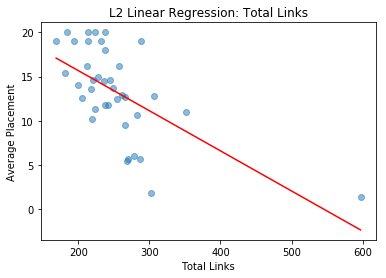

slope: -0.0453468493518406
r: -0.6183431551115334
p: 3.5158841230538114e-05
std_err 0.009605901867460702



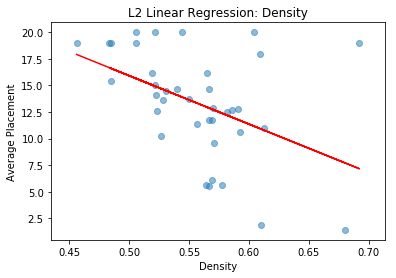

slope: -45.55364682847384
r: -0.4458639741530254
p: 0.005023456028945225
std_err 15.241981443744063



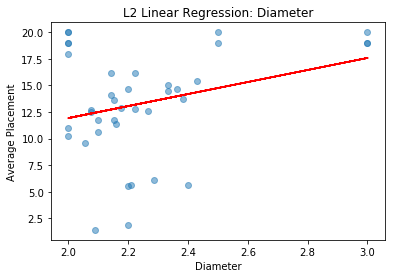

slope: 5.659563583218859
r: 0.29643412375260864
p: 0.07073709037147892
std_err 3.039002854679263



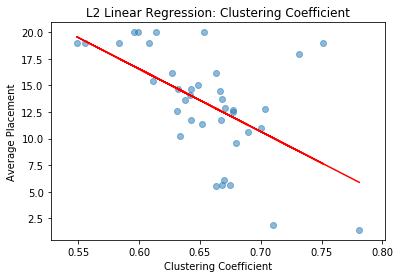

slope: -58.959810573030474
r: -0.5598267534373438
p: 0.00025764764461691487
std_err 14.544579975392601



In [21]:
metrics = ["Total Links", "Density", "Diameter", "Clustering Coefficient"]

for i in range(4):

    X = []
    y = []

    for team in ordered_teams:
        X.append(ordered_teams[team][i])
        y.append(placements[team])

    slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
    
    yPred1 = [intercept + slope * x for x in X]
    plt.scatter(X, y,alpha=0.5)
    plt.plot(X, yPred1, 'r', label="Linear")
    plt.title("L2 Linear Regression: " + metrics[i])
    plt.ylabel("Average Placement")
    plt.xlabel(metrics[i])
    plt.show()
    
    print("slope:", slope)
    print("r:", r_value)
    print("p:", p_value)
    print("std_err", std_err)
    print()